In [1]:
import numpy as np
import TensorFrost as tf
import matplotlib.pyplot as plt

tf.initialize(tf.cpu)

def BitonicSort(keys, values):
    element_count = keys.shape[0]
    log2_count = tf.int(tf.ceil(tf.log2(tf.float(element_count))))
    count_round = 1 << log2_count
    idx = tf.indices([count_round / 2])[0]
    with tf.loop(log2_count) as k:
        with tf.loop(k+1) as j:
            s = 1 << (k-j)
            m_inner = s - 1
            m_outer = ~m_inner
            m_xor = s + tf.select(j == 0, m_inner, 0)

            id1 = (2*(idx & m_outer) + (idx & m_inner))
            id2 = id1 ^ m_xor

            key1, key2 = keys[id1], keys[id2]
            with tf.if_cond((key1 >= key2) & (id1 < element_count) & (id2 < element_count)):
                val1, val2 = values[id1], values[id2]
                keys[id1] = key2
                keys[id2] = key1
                values[id1] = val2
                values[id2] = val1
    
    return keys, values

def Bitonic():
    keys = tf.input([-1], tf.int32)
    values = tf.input([-1], tf.int32)
    sorted_keys, sorted_values = BitonicSort(keys, values)
    return sorted_keys, sorted_values

sort_program = tf.compile(Bitonic)

TensorFrost module loaded!
Bitonic:
  Kernel count: 1
  Intermediate buffers: 0
  Host readbacks: 0
  Host writes: 0
  Lines of generated code: 555
  IR Compile time: 1.504400 ms
  Host Compile time: 1431.956299 ms



In [2]:
# all_kernels = tf.get_all_generated_kernels()
# print("Generated kernels:")
# for k in all_kernels:
#     print(k[0][2])

Error: 0


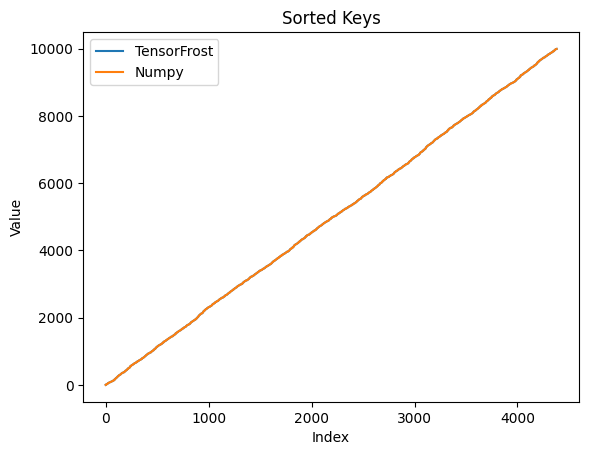

In [3]:
# Generate some random values
N = 4381
np.random.seed(0)
keys = np.random.randint(0, 10000, N)
values = np.arange(N)

# Sort the keys
keys_tf = tf.tensor(keys)
values_tf = tf.tensor(values)
sorted_keys, sorted_values = sort_program(keys_tf, values_tf)
sorted_keys = sorted_keys.numpy
sorted_values = sorted_values.numpy

# Sort the keys using numpy
data = np.column_stack((keys, values))
data = data[data[:, 0].argsort()]

# Compare the results
error = np.sum(np.abs(sorted_keys - data[:, 0]))
print('Error:', error)

# Plot the sorted keys
plt.plot(sorted_keys)
plt.plot(data[:, 0])
plt.title('Sorted Keys')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend(['TensorFrost', 'Numpy'])
plt.show()